In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.integrate import ode, solve_ivp

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Conceptual-models-of-Ocean-Circulation" data-toc-modified-id="Conceptual-models-of-Ocean-Circulation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Conceptual models of Ocean Circulation</a></span><ul class="toc-item"><li><span><a href="#0.-Context:-Dansgaard-Oeschger-events" data-toc-modified-id="0.-Context:-Dansgaard-Oeschger-events-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>0. Context: Dansgaard-Oeschger events</a></span></li><li><span><a href="#I.-The-Stommel-model" data-toc-modified-id="I.-The-Stommel-model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>I. The Stommel model</a></span><ul class="toc-item"><li><span><a href="#I.0.-Derivation-of-the-Stommel-model" data-toc-modified-id="I.0.-Derivation-of-the-Stommel-model-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>I.0. Derivation of the Stommel model</a></span></li><li><span><a href="#I.1.-Multiple-Equilibria-of-the-Stommel-model" data-toc-modified-id="I.1.-Multiple-Equilibria-of-the-Stommel-model-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>I.1. Multiple Equilibria of the Stommel model</a></span></li><li><span><a href="#I.2.-Noise-induced-transitions-in-the-Stommel-model" data-toc-modified-id="I.2.-Noise-induced-transitions-in-the-Stommel-model-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>I.2. Noise-induced transitions in the Stommel model</a></span></li><li><span><a href="#I.3.-Stochastic-resonance-in-the-Stommel-model" data-toc-modified-id="I.3.-Stochastic-resonance-in-the-Stommel-model-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>I.3. Stochastic resonance in the Stommel model</a></span></li></ul></li><li><span><a href="#II.-The-Welander-Model" data-toc-modified-id="II.-The-Welander-Model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>II. The Welander Model</a></span><ul class="toc-item"><li><span><a href="#II.0.-Theoretical-study" data-toc-modified-id="II.0.-Theoretical-study-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>II.0. Theoretical study</a></span></li><li><span><a href="#II.1.-Numerical-integration" data-toc-modified-id="II.1.-Numerical-integration-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>II.1. Numerical integration</a></span></li></ul></li></ul></li><li><span><a href="#Further-reading" data-toc-modified-id="Further-reading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Further reading</a></span></li></ul></div>

# Conceptual models of Ocean Circulation

The goal of this notebook is to explore some dynamical mechanisms which could account for internal variability of the ocean at the millenial scale: multiple equilibria and transitions between them, and self-sustained oscillations.

## 0. Context: Dansgaard-Oeschger events

Over the past million years, the Earth has undergone oscillations between glacial climates, characterized by ice caps at high latitudes much larger than today, and (much shorter) interglacial climates.
While the detailed processes underlying these glacial-interglacial cycles are not fully elucidated yet, their periodicity appears to be related to secular variations in Earth's orbital parameters.
Over the last glacial period, faster events superimposed onto these slow, regular variations.
Such events can be seen for instance by analyzing the relative abundance of the two stable isotopes of oxygen in ice cores, $^{16}O$ and $^{18}O$.
Below, we plot a time series of the *isotopic ratio* $\delta^{18}O = \left(\frac{^{18}O}{^{16}O}\right)_{sample}/\left(\frac{^{18}O}{^{16}O}\right)_{reference}-1$ from the [NorthGRIP project](https://en.wikipedia.org/wiki/North_Greenland_Ice_Core_Project).

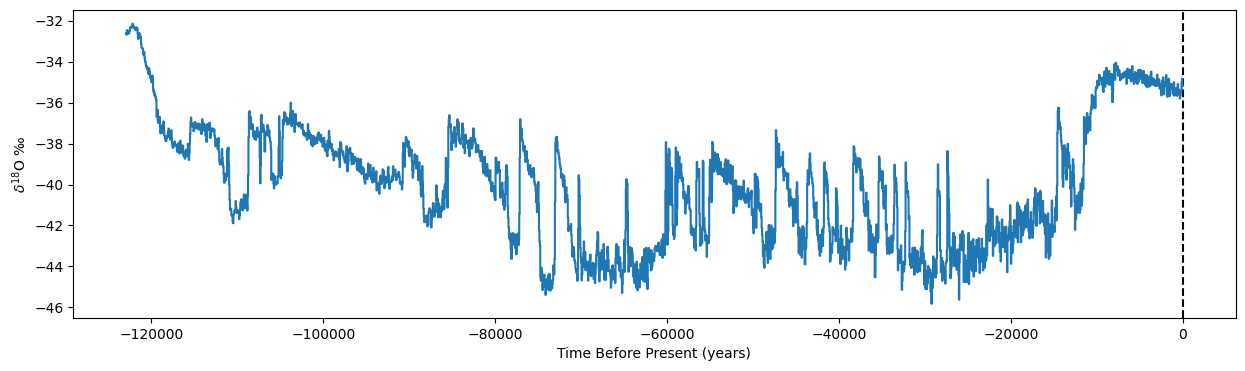

In [45]:
ngrip_d18O = np.loadtxt("NGRIP_d18O_50yrs.txt", skiprows=25)
time_before = ngrip_d18O[:, 0]
isotopic_ratio =  ngrip_d18O[:, 1]

plt.figure(figsize=(15, 4))
ax = plt.axes(xlabel='Time Before Present (years)', ylabel=u'$\delta^{18}$O ‰')
plt.axvline(x=0, linestyle= "--", c='k')
ax.plot(-time_before,  isotopic_ratio);

This can be interpreted as a proxy for temperature. When $\delta^{18}O$ is smaller (more negative), the climate is colder, and when it is larger the climate is warmer.
Time on this 1st figure goes from right to left.
The stable, approximately 10 000 year long, period just before present (with $\delta^{18}O\approx -35$ ‰) is our interglacial, called the Holocene.
At the far end of the record, roughly **120 000 years ago**, is the **previous interglacial**, called the **Eemian**, which according to our interpretation of the proxy was a bit warmer than the Holocene.
Now, during the ice age that prevailed between these two periods, the record exhibits **many spikes corresponding to abrupt warming events**, following by a gradual cooling back to the glacial $\delta^{18}O\approx -44$ ‰ baseline.
These events, called *Dansgaard-Oeschger events* , after the glaciologists who identified them, occur a bit erratically, but with a **typical timescale which is on the order of 1000 years**.
This does not correspond to any known external forcing of the climate system.
Hence, such variability must find its source in the **internal dynamics of the climate system**.
Specifically, it is believed that the ocean circulation plays an important role in these events.
The goal of this notebook is to explore some mechanisms which could account for internal variability of the ocean at such time scales: multiple equilibria and transitions between them, and self-sustained oscillations.

To do so we shall only use conceptual or "toy" models based on a **simple representation of the ocean as several homogeneous boxes exchanging heat and salinity through a buoyancy-driven circulation**. From a technical point of view, this means that we will only study dynamical systems with a few degrees of freedom, rather than the full partial differential equations describing ocean dynamics.

## I. The Stommel model

### I.0. Derivation of the Stommel model

*In this section, we introduce the relevant physical quantities for the model and derive the evolution equation (in non-dimensional form) for the salinity difference. No numerical computations are needed.*



Perhaps the simplest conceptual model of the meridional ocean circulation goes back to Stommel (1961). The model consists of two homogeneous boxes characterized by temperatures $T_1, T_2$ and salinities $S_1, S_2$ (expressed in $g.kg^{-1}$) representing the polar and tropical regions, respectively (see schematic below).

![model](stommel_model.png)

A salt flux $\Sigma$ (in $g.s^{-1}$) is imposed into the tropical box, and the polar box exports the same amount of salt to ensure global salt conservation.
The properties of the two ocean boxes are mixed by the overturning circulation.
We denote $m$ the flow rate (in $m^3.s^{-1}$) in the surface branch of the overturning circulation.
To ensure global mass conservation, the return flow at the bottom of the ocean must have the same flow rate $m$.
As far as the mixing of water mass properties (temperature, salinity) are concerned, the direction of the overturning circulation (northwards surface flow and southwards bottom flow, or the converse) does not matter. Hence $m$ will always be a positive quantity here. 

Assuming that both boxes have the same volume $V$, the equations for conservation of salt mass and total mass can be combined to yield the evolution equation for salinity in each box:
\begin{align*}
\frac{dS_1}{dt} &= -\frac{\Sigma}{\rho_0 V}+ \frac{m}{V} (S_2-S_1),\\
\frac{dS_2}{dt} &= \frac{\Sigma}{\rho_0 V}+ \frac{m}{V} (S_1-S_2),\\
\end{align*}
and for the salinity difference $\Delta S=S_2-S_1$:
\begin{align*}
\frac{d\Delta S}{dt} &= \frac{2\Sigma}{\rho_0 V}-\frac{2m}{V}\Delta S,
\end{align*}
with $\rho_0$ a reference density for seawater.
We use a linear equation of state for seawater: $\rho=\rho_0\lbrack 1-\alpha (T-T_0)+\beta(S-S_0)\rbrack$.

The temperature difference $\Delta T=T_2-T_1$ is assumed constant.

Several choices for the overturning circulation flow rate $m$ can be made. The original paper by Stommel assumes that it is proportional to $|\Delta \rho|=|\rho_2-\rho_1|$. Here, following Cessi (1994), we adopt the model $\frac{2m}{V} = \frac{1}{t_d}+\frac{q}{V}\frac{(\Delta \rho)^2}{\rho_0^2}$, where $t_d$ is a diffusion time and $q$ an empirical transport coefficient.

Introducing the non-dimensional variable $s=\frac{\beta \Delta S}{\alpha \Delta T}$ and rescaling time with the diffusive time $t_d$, the model reduces to:
\begin{equation*}
\dot{s} = F-s(1+\mu^2(1-s)^2) \equiv f(s),
\end{equation*}
with $F=\frac{2\beta t_d}{\alpha \Delta T \rho_0 V}\Sigma $ and $\mu^2=\frac{q t_d (\alpha \Delta T)^2}{V}$.

**Q.** In the current climate, what is the sign of $F$ and $s$?

**Q.** Show that $\Delta\rho < 0$ if and only if $s< 1$. Where should deep water form when this condition is satisfied? Does it correspond to current climate?

**Q.** Check that $F=0$, $s=0$ and $F=1$, $s=1$ are equilibria of the system, regardless of the value of $\mu$.

Cessi (1994) discusses the estimate of parameter values for the model. We should adopt the same choice here. They are given in the following table:

| Parameter | Value   |  Unit   |
|-----------|---------|---------|
| $\alpha$  | 1e-4    | $K^{-1}$|
| $\beta$   | 7.6e-4  |         |
| $t_d$     | 180     | years   |
| $q$       | 1.92e12 | $m^3.s^{-1}$ |
| $V$       | 11137500| $km^3$  |
| $\Delta T$| 25      | K       |

In [46]:
alpha = 1e-4
beta = 7.6e-4
td = 180*365*24*3600
q = 1.92e12
V = 11137500*1000**3
DeltaT = 25

mu_cessi = np.sqrt(q*td*(alpha*DeltaT)**2/V)
print(f"mu= {mu_cessi:.2f} (dimentionless)")

mu= 2.47 (dimentionless)


### I.1. Multiple Equilibria of the Stommel model

**Q1.** How many equilibrium states does the system have at most? Check analytically that there is more than one equilibrium if and only if $\mu^2>3$. 
*No numerical computation is needed.*

The system has at most 3 fixed points because the right-hand side is a polynomial of degree 3. When that is the case one fixed point should be unstable and the other two should be stable.

It can be checked by studying the function $s \longmapsto s(1+\mu^2(1-s)^2)$ that its derivative as a minimum value equal to $1-\mu^2/3$. Hence if $\mu^2\leq 3$ the function is monotonic and there can be only one equilibrium. If on the other hand $\mu^2 >3$ the function is nott monotonic and there can be multiple equilibria for some values of $F$.

**Q2.** Now plot the vector field $f$ as a function of $s$ and $F$, for fixed values of $\mu$ (you can use for instance $\mu=1$, $2$ and $2.5$). For each value of $\mu$, you can use a filled contour plot (`plt.contourf`) to show the values of $f$, and draw on top of it (with `plt.contour`) the contour line $f=0$, which corresponds to the equilibrium states. For each value of $\mu$, discuss the number of equilibrium states, their stability, and the direction of the overturning circulation for each of them. You can use the definition of $f$ in the following cell.

In [47]:
def f(_t: float, s: float, mu: float, F: float) -> float:
    """ The vector field for the Stommel model """
    return F-s*(1+mu**2*(1-s)**2)

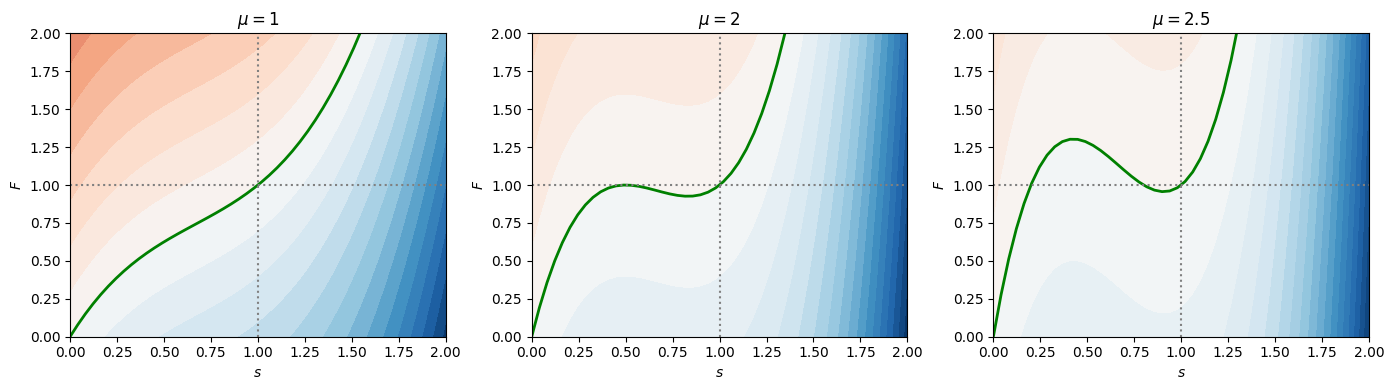

In [48]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
yvec = np.linspace(0, 2, 50)
Fvec = np.linspace(0, 2, 50)
for mu, ax in zip((1, 2, 2.5), (ax1, ax2, ax3)):
    ax.set_xlabel(r'$s$')
    ax.set_ylabel(r'$F$')
    ax.set_title(f'$\mu=${mu}')
    tab = np.array([[f(0, s, mu, F) for s in yvec] for F in Fvec])
    ax.contourf(yvec, Fvec, tab, 20, cmap='RdBu_r', norm=colors.CenteredNorm())
    ax.contour(yvec, Fvec, tab, [0], colors='green', linewidths=2)
    ax.axvline(x=1, ls='dotted', color='gray')
    ax.axhline(y=1, ls='dotted', color='gray')
plt.tight_layout()

For $\mu=1$, there is always a unique stable equilibrium. As the salt flux increases, there is a smooth transition from a thermal circulation (downwelling where the water is colder, $s<1$, in the arctic ocean) to a haline circulation (downwelling where the water is saltier, $s>1$, in the equator). The transition occurs for $F=1$.

For $\mu=2$, there is a range of forcings for which the system admits multiple equilibria (two stable ones and an unstable one). However, all these equilibrium states correspond to thermal circulations. Like in the previous case, for $F>1$ we have a transition to a reversed overturning circulation.

For $\mu=3$, the range of bistability is larger and straddles the $F=1$ line. This means that in a certain range of forcing amplitudes, a conventional overturning circulation (corresponding to the equilibrium state with $s<1$) can coexist with a reversed one (corresponding to the equilibrium state with $s>1$).

Note that in each case the stability of the equilibrium state can be seen easily: it is determined by the sign of the derivative of $f$ with respect to $y$. This can be seen graphically: if $f$ is positive left of the equilibrium and negative right of it, it is stable, and unstable in the opposite case.

**Q3.** We are now going to integrate numerically the differential equation defining the model for a range of initial conditions $s_0 \in [0, 2]$ and for different parameter values. Show all the trajectories on the same plot, and make one plot for each value of $F$ in $(0.5, 1, 1.5)$ and $\mu$ in $(1, 2.5)$.

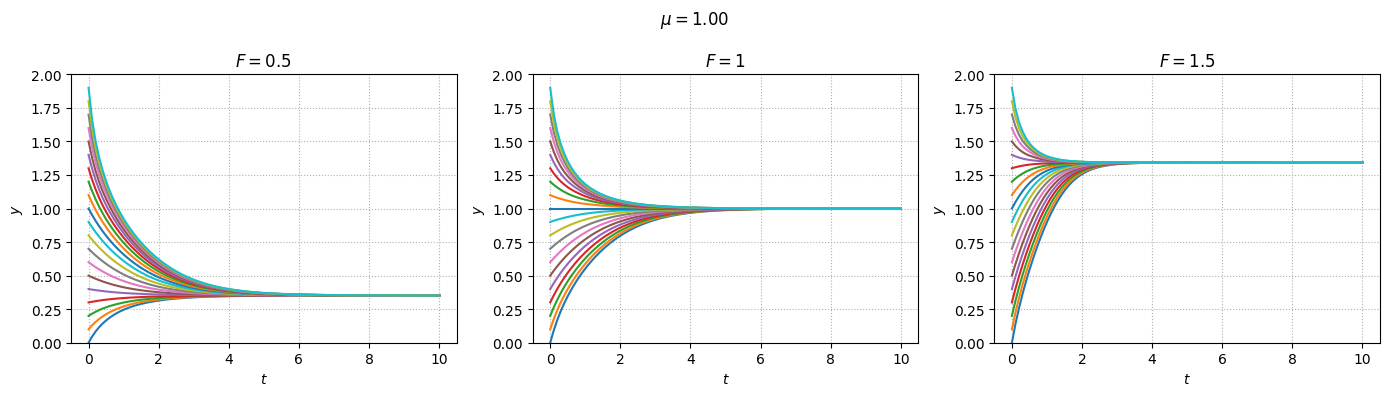

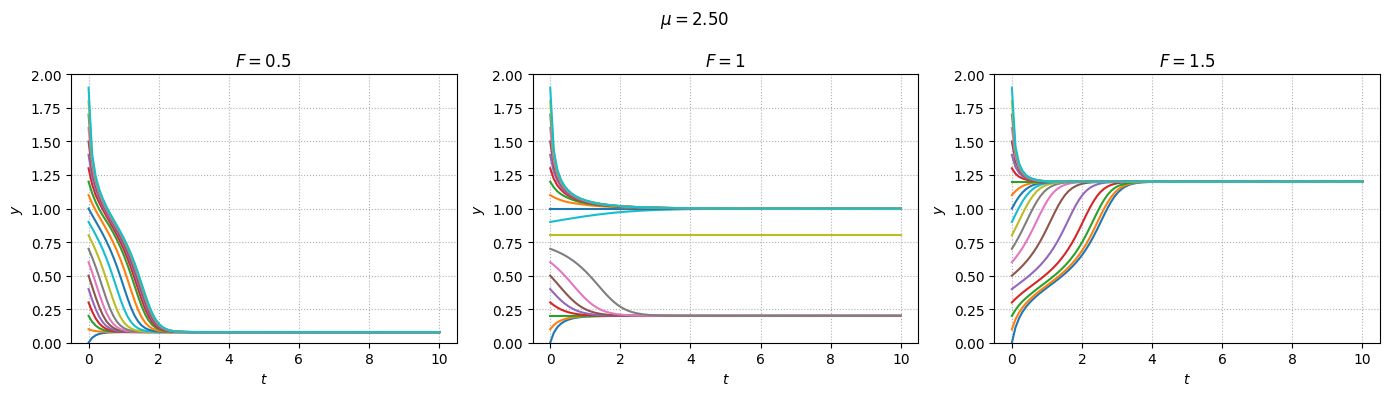

In [91]:
def plot_trajectory_mu(mu: float) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
    fig.suptitle(rf'$\mu={mu:.2f}$')
    for F, ax in zip((0.5, 1, 1.5), (ax1, ax2, ax3)):
        ax.set_xlabel(r'$t$')
        ax.set_ylabel(r'$y$')
        ax.set_ylim((0, 2))
        ax.grid(True, ls='dotted')
        ax.set_title(r'$F=$'+str(F))
        for s0 in np.arange(0, 2, 0.1):
            # solve the ode and plot
            trajectory = solve_ivp(f, args=(mu, F), t_span=(0,10), y0=[s0], t_eval=np.linspace(0,10,100))
            ax.plot(trajectory.t, trajectory.y[0])
    plt.tight_layout()

plot_trajectory_mu(1)
plot_trajectory_mu(2.5)

**Q4.** Now let us do an *hysteresis experiment*: we integrate the differential equation with a time-dependent forcing $F$. If the forcing changes slowly compared to the relaxation time of the system, we should always remain close to equilibriium states. **However, if the forcing changes too fast, the system will not be able to track its equilibrium state**. This may lead to the so-called **dynamical hysteresis** phenomenon, where the hysteresis loop is larger than what would be obtained with an adiabatic variation of the parameter. 

In [52]:
def hysteresis(model, dt, Fstart, Fend, dF):
    F = Fstart
    model.set_f_params(2, F) # Set extra parameters for user-supplied function f.
    while F <= Fend:
        yield F, model.integrate(model.t+dt)[0]
        F += dF
        model.set_f_params(2, F)
    while F >= Fstart:
        yield F, model.integrate(model.t+dt)[0]
        F -= dF
        model.set_f_params(2, F)

Text(0.5, 1.0, 'Hysteresis when F varies around 1')

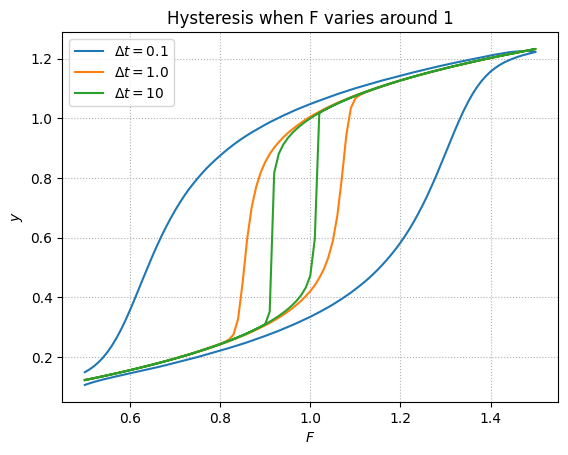

In [53]:
Fstart, Fend, dF = 0.5, 1.5, 0.01 # centered around F=1

ax = plt.axes(xlabel=r'$F$', ylabel=r'$y$')
ax.grid(True, ls='dotted')

stommel.set_initial_value(0.1, 0)

for deltat in (0.1, 1.0, 10): # time step of change of F
    trajectory = np.array([(F, y) 
                           for F,y in hysteresis(stommel, deltat, Fstart, Fend, dF)])
    ax.plot(trajectory[:, 0], trajectory[:, 1], 
            label=r'$\Delta t=$'+str(deltat))
ax.legend();
ax.set_title("Hysteresis when F varies around 1")

### I.2. Noise-induced transitions in the Stommel model

We now consider that the freshwater flux can fluctuate. We represent these fluctuations by white noise added to the mean freshwater flux. The new model takes the form of the following *stochastic differential equation*:
\begin{equation*}
dy_t = \lbrack F-y_t(1+\mu^ 2(1-y_t)^2) \rbrack dt + \sqrt{2D}dW_t,
\end{equation*}
where $W$ is a Wiener process, and the diffusion coefficient $D$ controls the amplitude of the fluctuations.

We shall work in the bistability regime with $\mu^2=6.2$ and $F=1.1$. We assume that the fluctuations of the freshwater flux are on the order of 20%: $\sqrt{2D}= 0.2$, i.e. $D=0.02$.

Numerical integration of stochastic differential equations require specific methods. The goal here is not to study these methods, hence we shall simply use an existing python package which implements them. For more information, see https://stochrare.readthedocs.io/en/latest/notebooks/Diffusion1D.html and the reference book by Kloeden and Platen (see the *Further Reading* section at the end of this document).

In [54]:
import stochrare as sr
stommel_stochastic = sr.dynamics.diffusion1d.ConstantDiffusionProcess1D(lambda y, t: f(t, y, np.sqrt(6.2), 1.1), 0.02)

**Q1.** Sample a long (several hundreds of time units) realization of the stochastic process (using the `trajectory` method of the `stommel_stochastic` object). Check that it exhibits transitions between the two stable states. If it does not, sample a new one until it does. Do the transitions appear to occur at regular interval or randomly?

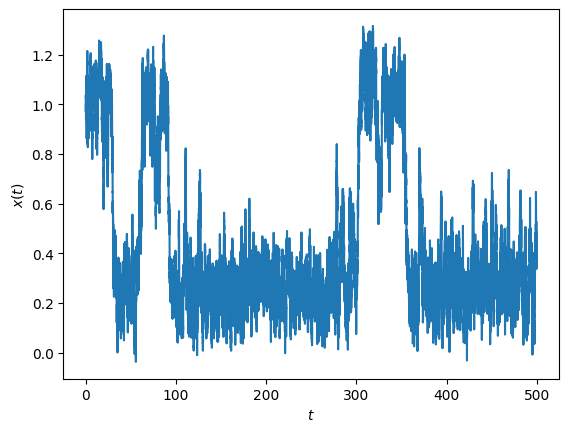

In [55]:
stommel_stochastic.trajectoryplot(stommel_stochastic.trajectory(1, 0, dt=0.01, T=500));

The model above takes the form of a classical problem in statistical physics, corresponding to the dynamics of an overdamped particle in a potential (the vector field $f$ derives from a potential: $f(y)=-V'(y)$ - here it is trivial because the system is 1D). It is a standard exercise to compute the statistical properties of the system, such as for instance the stationary probability density function, or the distribution of transition times.
Let us start with the probability density function $p(y, t)$. It obeys the Fokker-Planck equation:
\begin{equation*}
\frac{\partial p}{\partial t} = \frac{\partial (V'(y) p)}{\partial y}+D\frac{\partial^2 p}{\partial y^2}.
\end{equation*}
It is easily seen that the stationary solution is $p_\infty(y) = Z e^{-\frac{V(y)}{D}}$ where $Z$ is a normalization constant.

**Q2.** Sample numerically the stationary probability density function, and compare it to the theoretical result. To do so, use the definition of the potental in the following cell:

In [56]:
def potential(y: float, F: float, mu: float) -> float:
    """ The potential from which the vector field of the Stommel model derives. """
    return y**2/2+mu**2*(y**4/4-2*y**3/3+y**2/2)-F*y

In [57]:
_, y = stommel_stochastic.trajectory(1, 0, dt=0.01, T=1000)

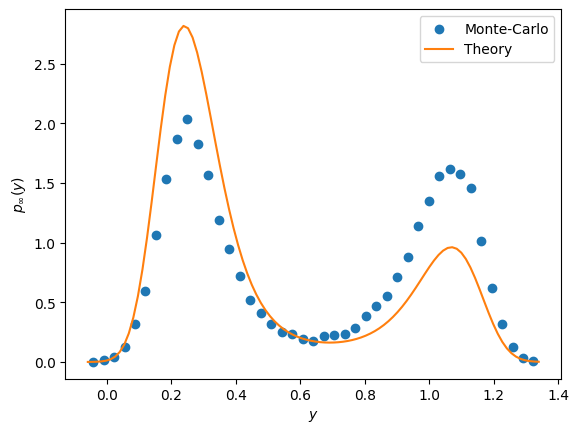

In [58]:
p_num, bin_edges = np.histogram(y, bins='auto', density=True)
yvec = np.linspace(np.min(bin_edges), np.max(bin_edges), num=100)
p_th = np.exp(-potential(yvec, 1.1, np.sqrt(6.2))/0.02)
p_th /= np.trapz(p_th, x=yvec)
ax = plt.axes(xlabel=r'$y$', ylabel=r'$p_\infty(y)$')
ax.scatter(0.5*(bin_edges[1:]+bin_edges[:-1]), p_num, label='Monte-Carlo')
ax.plot(yvec, p_th, label='Theory', color='C1')
plt.legend();

**Q3.** Now we want to study the statistics of the transition time, say for a transition from the "on"-state to the "off"-state of the meridional overturning circulation. We define the *first passage time* as follows:
\begin{equation}
\tau = \inf\{ t>0, y_t > 1 | y_0 = 0.2\}
\end{equation}
Sample numerically many realizations of $\tau$, and compute its probability density function. Compare it to an exponential distribution: $p(\tau)=\lambda e^{-\lambda\tau}$ with a parameter $\lambda$ that you should identify. Again, you should not write the numerical implementation yourselves: instead use the `FirstPassageProcess` object from the `stochrare` package (you should use its `escapetime_sample` method):

In [59]:
tau = sr.firstpassage.FirstPassageProcess(stommel_stochastic)

In [60]:
tau_samples = tau.escapetime_sample(0.2, 0, 1, ntraj=10000)

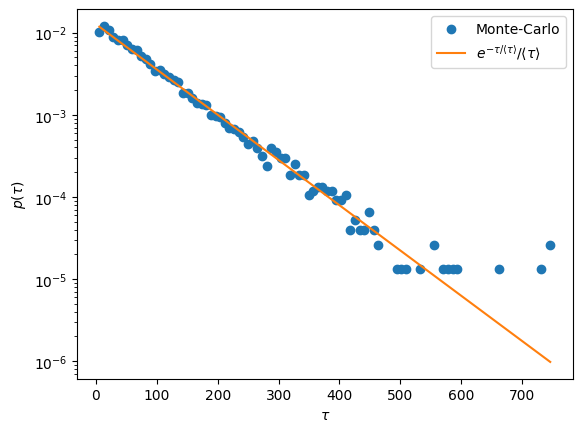

In [61]:
p_tau, bin_edges = np.histogram(tau_samples, bins='auto', density=True)
tau_avg = np.mean(tau_samples)
ax = plt.axes(xlabel=r'$\tau$', ylabel=r'$p(\tau)$', yscale='log')
ax.scatter(0.5*(bin_edges[1:]+bin_edges[:-1]), p_tau, label='Monte-Carlo')
ax.plot(0.5*(bin_edges[1:]+bin_edges[:-1]), np.exp(-0.5*(bin_edges[1:]+bin_edges[:-1])/tau_avg)/tau_avg, label=r'$e^{-\tau/\langle \tau \rangle}/\langle \tau \rangle$', color='C1')
plt.legend();

**Q4.** Is the timescale of transitions obtained with this model compatible with the timescales associated with Dansgaard-Oeschger events?

In [62]:
tau_avg

78.76153

If we look at the average transition time, we find aroud 80 time units for the value of the parameters given here, which is about 15 000 years. This is a bit large but we should not give too much importance to this single value, as it would be easy to change it by modifying the parameters (for instance we could decrease the mean first-passage time by increasing the amplitude of the noise). Perhaps a more important remark is that the distribution of the transition times is very wide: the standard deviation is equal to the mean. In other words, there is no preferred transition time; it is not clear whether this is the case for Dansgaard-Oeschger events.

### I.3. Stochastic resonance in the Stommel model

The noise-induced transitions between the two stable states of the Stommel model occur on a very wide variety of timescales. On the other hand, although they do exhibit some irregular character, the Dansgaard-Oeschger events in the paleoclimate proxies seem to have a distribution more centered around $\sim$ 1500 years. It has been suggested that transitions between two stable states of the meridional overturning circulation could be "locked" to a specific period through a phenomenon called *stochastic resonance* (see e.g. Velez-Belchi et al. (2001)). We are going to illustrate this mechanism here.

The main idea is to add a periodic component to the freshwater forcing: we replace $F$ by $F+A\sin(2\pi t/T)$. Following Velez-Belchi et al., we shall use $A=0.05$ (periodic modulation of the freshwater flux by about 5%) and $T=42 000$ years, corresponding to orbital forcing associated with obliquity variations.

In [63]:
stommel_stochastic_periodic = sr.dynamics.diffusion1d.ConstantDiffusionProcess1D(lambda y, t: f(t, y, np.sqrt(6.2), 1.1+0.05*np.sin(2*np.pi*t/(42000/180))), 0.011)

**Q1.** Sample a long trajectory (about one thousand time units) with $\mu^2=6.2$, $F=1.1$, $A=0.05$, $T*t_d=42000$ years and $D=0.011$. Check qualitatively that shutdown of the meridional overturning circulation tends to be in phase with the forcing (it occurs preferentially when $F+A\sin(2\pi t/T)$ is maximum) but does not occur at each period. Is this behavior the same for transittions between the off-state and the on-state? Can you speculate why? Would there be transitions without the noise?

In [64]:
t, y = stommel_stochastic_periodic.trajectory(0.2, 0, dt=0.01, T=3000)

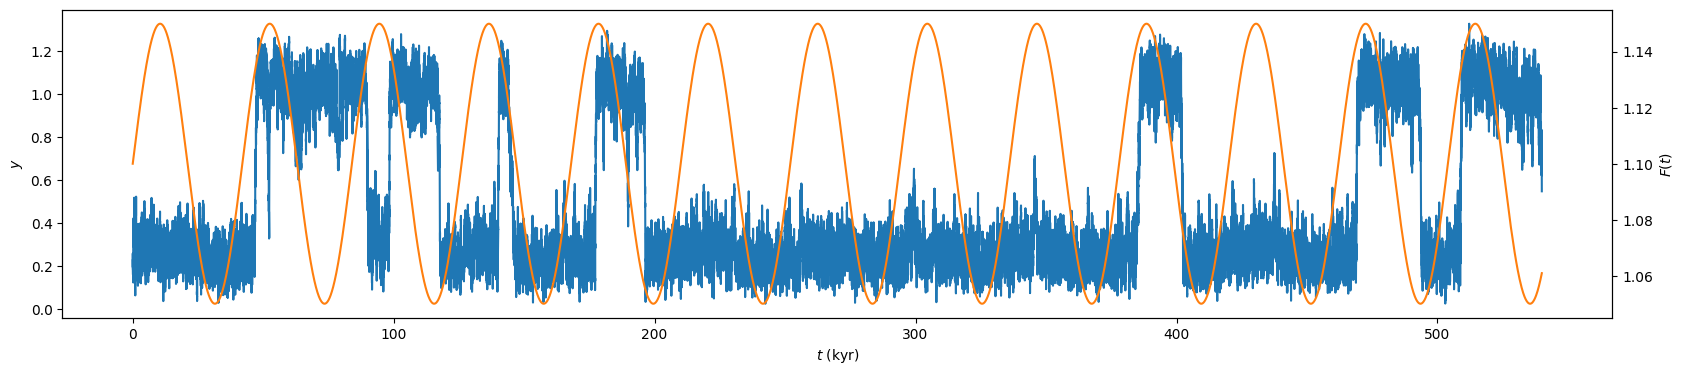

In [65]:
fig = plt.figure(figsize=(20, 4))
ax = plt.axes(xlabel=r'$t$ (kyr)', ylabel=r'$y$')
ax2 = ax.twinx()
ax2.set_ylabel(r'$F(t)$')
ax.plot(t*0.180, y)
ax2.plot(t*0.180, 1.1+0.05*np.sin(2*np.pi*t/(42000/180)), color='C1');

We observe that transitions between the on-state of the meridional overturning circulation occur in phase with the forcing (sometimes a bit before the maximum, sometimes a bit after, but almost always close to it).
Sometimes there are no transitions, although the forcing is maximum.
This is because the forcing amplitude is not sufficient for transitions to occur in the deterministic system, we still need a specific realization of the noise to drive the system beyond the potential barrier (which is only made smaller by the periodic forcing, therefore making hte transition more likely).

Similarly, transitions between the off-state and the on-state occur preferentially during minima of the freshwater forcing.
In this case, there seem to be less "missed opportunities": the system rarely remains in the off-state for more than half-a-period.
One interpretation is that the potential barrier for transitions in this direction is shallower.

**Q2.** Estimate the power spectrum of the system and plot it, zooming on the low frequencies (say, periods of 5000 years or larger). Compare it with the power spectrum of the system with time-independent forcing. *You might need to average over many realizations of the spectrum.*

In [66]:
data_periodic = np.array([stommel_stochastic_periodic.trajectory(0.2, 0, dt=0.01, T=3000)[1] for _ in range (100)])

In [67]:
spectrum_periodic = np.mean(np.abs(np.fft.rfft(data_periodic, norm='ortho'))**2, axis=0)

In [68]:
data_stochastic = np.array([stommel_stochastic.trajectory(0.2, 0, dt=0.01, T=3000)[1] for _ in range (100)])
spectrum_stochastic = np.mean(np.abs(np.fft.rfft(data_stochastic, norm='ortho'))**2, axis=0)

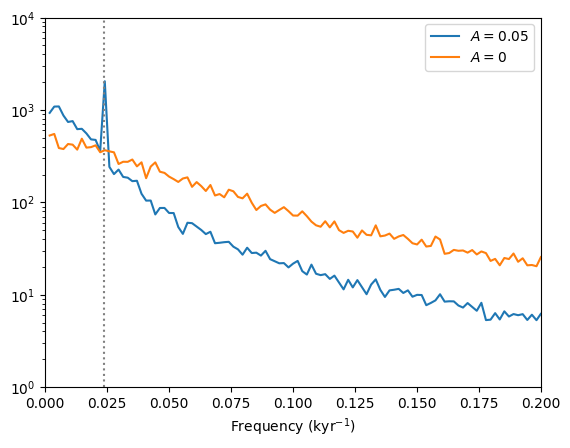

In [69]:
ax = plt.axes(yscale='log', xlabel=r'Frequency (kyr$^{-1}$)', xlim=(0, 0.2), ylim=(1, 1e4))
ax.plot(np.fft.rfftfreq(len(data_periodic[0]), 0.01*0.180)[1:], spectrum_periodic[1:], label=r'$A=0.05$')
ax.plot(np.fft.rfftfreq(len(data_stochastic[0]), 0.01*0.180)[1:], spectrum_stochastic[1:], label=r'$A=0$')
ax.legend()
ax.axvline(x=1/42., ls='dotted', color='grey');

In the system with periodic forcing, we see a clear peak in the spectrum corresponding to the forcing frequency, at 42 kyr.
On the other hand, in the system with time-independent forcing, only the continuous background spectrum remains.

**Q3.** Proceeding as in section I.2, estimate the distribution of the first-passage time for the system with periodic forcing. Compare it to the system with time-independant forcing.

In [70]:
tau_periodic = sr.firstpassage.FirstPassageProcess(stommel_stochastic_periodic)
tau_periodic_samples = tau_periodic.escapetime_sample(0.2, 0, 1, ntraj=10000)

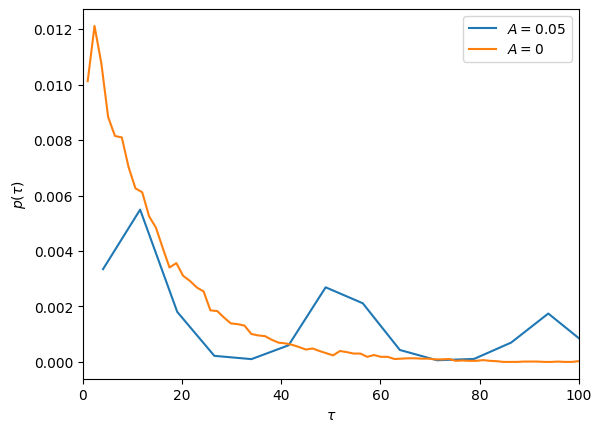

In [71]:
p_tau_periodic, bin_edges_periodic = np.histogram(tau_periodic_samples, bins='auto', density=True)
ax = plt.axes(xlabel=r'$\tau$', ylabel=r'$p(\tau)$', xlim=(0, 100))
ax.plot(0.5*(bin_edges_periodic[1:]+bin_edges_periodic[:-1])*0.18, p_tau_periodic, label=r'$A=0.05$')
ax.plot(0.5*(bin_edges[1:]+bin_edges[:-1])*0.18, p_tau, label=r'$A=0$')
plt.legend();

The PDF of first-passage time exhibits a peak close to the forcing period, unlike the system with time-independant forcing.

## II. The Welander Model

Another possibility for millenial variability in the ocean circulation is the existence of self-sustained oscillations. In this second part of the notebook, we shall see briefly one example of such a phenomenon, sometimes called *flip-flop oscillations*, in the context of the Welander model.

The Welander (1982) model is another conceptual model of the ocean circulation which focuses on vertical mixing between the surface and deep ocean. 
It is made of a box representing the surface ocean, with temperature $T_1$ and salinity $S_1$, and a box representing the deep ocean, with temperature $T_b$ and salinity $S_b$.

The surface box interacts with the environment, through relaxation terms $k_T(T_a-T_1)$ for the temperature and $k_S(S_a-S_1)$ for the salinity, where $T_a$ and $S_a$ are fixed.
It is also coupled to the deep ocean through convection, with a flow rate $c$.
The temperature $T_b$ and salinity $S_b$ in the abyss are assumed to be constant.

The equations for the model are therefore:
\begin{align*}
\frac{dT_1}{dt} &= k_T(T_a-T_1)+c(T_b-T_1),\\
\frac{dS_1}{dt} &= k_S(S_a-S_1) +c(S_b-S_1).
\end{align*}

If $c$ was a constant, the model would simply relax to a single equilibrium state.
But in fact, mixing should occur only when $\Delta \rho \equiv\rho_1-\rho_b >0$.
Here, we show that the non-linear nature of mixing leads to self-sustained oscillations of the surface ocean.

More precisely, we model mixing as a step function:
\begin{equation*}
c = c_0 \text{ if } \Delta\rho <0, c=c_1 \text{ if } \Delta \rho \geq 0,
\end{equation*}
with $0 < c_0 \ll 1$ (diffusive regime) and $c_1 \gg 1$ (convective regime).

### II.0. Theoretical study

Let us rewrite the equations in non-dimensional form by introducing $\Delta T=T_1-T_b$, $\Delta S=S_1-S_b$, $x=\frac{\Delta T}{T_a-T_b}$, $y=\frac{\Delta S}{S_a-S_b}$, $\tau=k_T t$, $\gamma=\frac{c}{k_T}$ and $\delta=\frac{k_S}{k_T}$. The equations read:
\begin{align*}
\frac{dx}{d\tau} &= 1- (1+\gamma)x,\\
\frac{dy}{d\tau} &= \delta -(\delta+\gamma)y.
\end{align*}
At steady-state, we must have $x^\star=\frac{1}{1+\gamma}$, $y^\star=\frac{\delta}{\delta+\gamma}$.
There are at most two fixed points corresponding to $\gamma=\gamma_0$ (diffusive regime) or $\gamma=\gamma_1$ (convective regime).
However, those fixed points can be reached only if $\Delta \rho$ has the correct sign for those values of $x$ and $y$.
It is easily seen that $\Delta\rho/\rho_0=\beta(S_a-S_b)(y-\mu x)$ with $\mu=\frac{\alpha(T_a-T_b)}{\beta(S_a-S_b)}$.
We assume that $S_a-S_b>0$, so that the sign of $\Delta \rho$ is the same as the sign of $y-\mu x$.

**Q0.** In the $(x, y)$ space, plot the line corresponding to the possible equilibrium states for all the values of $\gamma$, using the value $\delta=0.1$. Plot the line $y=\mu x$ with $\mu=0.2$. Which region corresponds to existence of the equilibrium with $\gamma=\gamma_0$ and which region corresponds to existence of the equilibrium with $\gamma=\gamma_1$? How many equilibrium states are there for $(\gamma_0,\gamma_1)=(0, 0.5)$, for $(\gamma_0,\gamma_1)=(1, 4)$ and for $(\gamma_0,\gamma_1)=(0.1, 5)$?

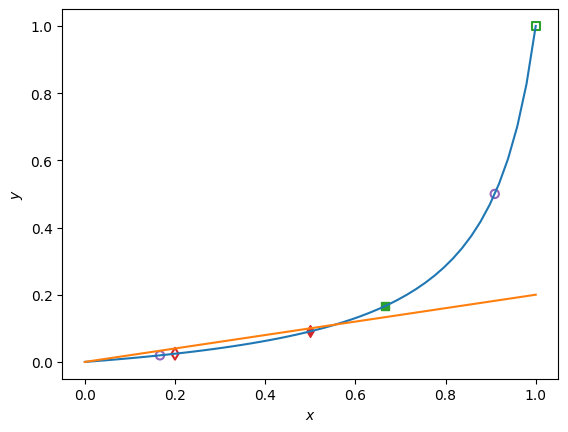

In [72]:
from matplotlib.markers import MarkerStyle
ax = plt.axes(xlabel=r'$x$', ylabel=r'$y$')
x = np.linspace(0, 1)
delta = 0.1
mu = 0.2
ax.plot(x, delta*x/(1+(delta-1)*x))
ax.plot(x, mu*x)
ax.scatter((1/(1+0),), (delta/(delta+0),), marker=MarkerStyle('s', fillstyle='none'), color='C2');
ax.scatter((1/(1+0.5), ), (delta/(0.5+delta), ), marker='s', color='C2');
ax.scatter((1/(1+1), ), (delta/(1+delta), ), marker='d', color='C3');
ax.scatter((1/(1+4),), (delta/(delta+4),), marker=MarkerStyle('d', fillstyle='none'), color='C3');
ax.scatter((1/(1+5), 1/(1+0.1)), (delta/(5+delta), delta/(delta+0.1)), marker=MarkerStyle('o', fillstyle='none'), color='C4');

The diffusive equilibrium can only exist below the $y=\mu x$ line, and the convective equilibrium can only exist above this line.
We can see that in the first case (square symbols), the diffusive equilibrium (open green square) is in the wrong region and is therefore not a fixed point for the system; there is only one fixed point, the convective one (filled green square).
In the second case, the converse is true: the diffusive state (filled red diamond) is a fixed point but not the convective state (open red diamond).
In the third case, both the diffusive and convective states (open purple circles) are in the wrong region, and the system has no fixed point. In this case, we can expect the system to exhibit self-sustained oscillations. This behavior exists as long as $\delta <1$ and $0 < \mu < 1$.

Note that if $\delta >1$ (the equilibrium line becomes concave) and $\mu >1$, there can be bistability for some range of $\gamma_0,\gamma_1$.

### II.1. Numerical integration

**Q1.** Integrate a trajectory for the parameter values originally suggested by Welander: $\delta=0.1, \mu=0.2, \gamma_1=5, \gamma_0=0$ and plot $x(\tau)$ and $y(\tau)$. What do you observe?

In [73]:
def deltarho(x: float, y: float, mu: float = 0.2) -> int:
    """ Compute the sign of the density difference given the reduced variables x and y """
    return 1 if y-mu*x > 0 else 0

In [74]:
def f_welander(t: float, X: np.ndarray, delta: float = 0.1, mu: float = 0.2, gamma1: float = 5, gamma0: float = 0) -> np.ndarray:
    """ The vector field for the Welander model. """
    gamma = gamma1 if deltarho(X[0], X[1], mu) > 0 else gamma0
    return (1-(1+gamma)*X[0], delta-(delta+gamma)*X[1])


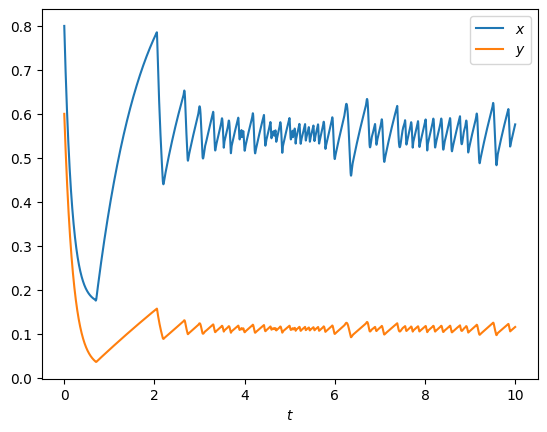

In [75]:
ax = plt.axes(xlabel=r'$t$')
sol = solve_ivp(f_welander, (0, 10), (0.8, 0.6), t_eval=np.linspace(0, 10, 10000))
ax.plot(sol.t, sol.y[0], label=r'$x$')
ax.plot(sol.t, sol.y[1], label=r'$y$')
ax.legend();

We observe oscillations but they do not correspond to a limit cycle (the amplitude of the oscillation varies). This seems to be a numerical problem. We give a solution in the next question.

**Q2.** To solve the numerical problem, we modify a little bit the mixing function:
\begin{equation*}
c = c_0 \text{ if } \Delta\rho <-\varepsilon, c=c_1 \text{ if } \Delta \rho \geq -\varepsilon,
\end{equation*}
with $\varepsilon >0$. How is the trajectory affected? (you can use $\varepsilon=0.01$ for instance)

In [76]:
def deltarho(x: float, y: float , mu: float = 0.2, epsilon:float = 0.01) -> int:
    """ Compute the sign of the density difference given the reduced variables x and y """
    return 1 if y-mu*x > -epsilon else 0

def f_welander(t: float, X: np.ndarray, delta: float = 0.1, mu: float = 0.2, gamma1: float = 5, gamma0: float = 0) -> np.ndarray:
    gamma = gamma1 if deltarho(X[0], X[1], mu) > 0 else gamma0
    return (1-(1+gamma)*X[0], delta-(delta+gamma)*X[1])

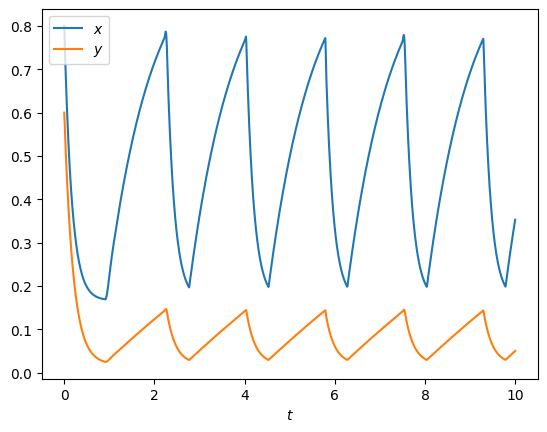

In [77]:
ax = plt.axes(xlabel=r'$t$')
sol = solve_ivp(f_welander, (0, 10), (0.8, 0.6), t_eval=np.linspace(0, 10, 10000))
ax.plot(sol.t, sol.y[0], label=r'$x$')
ax.plot(sol.t, sol.y[1], label=r'$y$')
ax.legend();

The trajectory now is much more regular. It seems to be a limit cycle.

It should be noted that the cycle has a saw-tooth shape, with slower increase of temperature and salinity followed by faster decrease. This will be explained in the next question.

**Q3.** Check that two trajectories initially on both side of the $y=\mu x$ line converge to the same limit cycle. Plot them in phase space $(x, y)$. Give a physical interpretation for the oscillation.

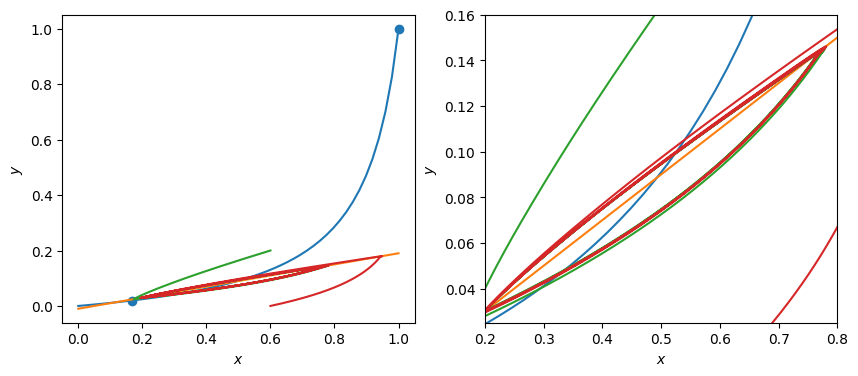

In [78]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
x = np.linspace(0, 1)
for ax in (ax1, ax2):
    ax.set_ylabel(r'$y$')
    ax.set_xlabel(r'$x$')
    ax.plot(x, 0.1*x/(1-0.9*x))
    ax.plot(x, 0.2*x-0.01)
    ax.scatter((1/6, 1), (0.1/5.1, 1))
ax2.set_xlim(0.2, 0.8)
ax2.set_ylim(0.025, 0.16)
for (x0, y0) in ((0.6, 0.2), (0.6, 0)):
    sol = solve_ivp(f_welander, (0, 10), (x0, y0), t_eval=np.linspace(0, 10, 10000))
    ax1.plot(sol.y[0], sol.y[1])
    ax2.plot(sol.y[0], sol.y[1])

We observe that the two trajectories converge to the same limit cycle.
This figure also shows us that as soon as the system is on on side of the $y=\mu x$ line, it is attracted by the "ghost fixed point" on the other side. The system therefore continuously attemps to relax to either the diffusive or the convective equilibrium, but oscillate between then because none of them can be reached.

Let us describe in more details the dynamics, focusing on the green trajectory for definiteness. Initially it is in the convective regime: the surface waters are denser than the bottom ones, therefore they start thinking and vertical mixing quickly decreases the surface temperature and salinity. Once teh column becomes stratified again, convection stops and the surface is isolated from the abyss. However, it is now made of cold fresh water, much colder and fresher than the environment. Hence, the relaxation term (which might be interpreted as the effect of horizontal mixing) increases the temperature and salinity again, albeit slower than convection decreased them. While that happens, the system is driven towards the values which correspond to the diffusive equilibrium with the abyss, which happens to be unstable for convection. Hence, after a while, surface waters are again denser than bottom waters, and vertical mixing starts again, and so on and so forth.

**Q4.** Which behavior do you expect when $\mu$ varies? Should we always have a limit cycle? Illustrate your answer by numerically integrating some representative trajectories. To do so, you can use slightly different parameters: $\gamma_0=0.5$ and $\gamma_1=2$.

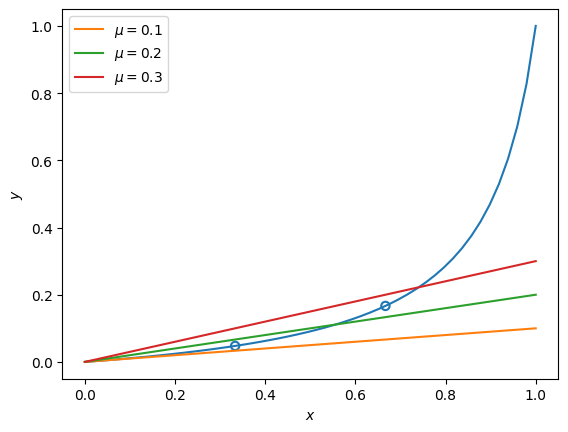

In [79]:
from matplotlib.markers import MarkerStyle
ax = plt.axes(xlabel=r'$x$', ylabel=r'$y$')
x = np.linspace(0, 1)
(delta, gamma0, gamma1) = (0.1, 0.5, 2)
ax.plot(x, delta*x/(1+(delta-1)*x))
ax.scatter((1/(1+2), 1/(1+0.5)), (delta/(2+delta), delta/(delta+0.5)), marker=MarkerStyle('o', fillstyle='none'), color='C0')
for mu in (0.1, 0.2, 0.3):
    ax.plot(x, mu*x, label=f'$\mu=${mu}')
ax.legend();

We can see on this figure that for small values of $\mu >0$ (e.g. $\mu=0.1$), the convective state should become a fixed point of the system (and it will be the only one). On the other hand, for $\mu$ sufficiently large (e.g. $\mu=0.3$), the diffusive state becomes the only fixed point. In between, we have a limit cycle. Hence, there should be two Hopf bifurcations, for values of $\mu$ for which the equilibrium states are on the $y=\mu x$ line, i.e. $\mu=\frac{y^\star}{x^\star}=\frac{\delta(1+\gamma)}{\delta+\gamma}$. 

In [80]:
mu0 = delta*(1+gamma0)/(delta+gamma0)
mu1 = delta*(1+gamma1)/(delta+gamma1)
print(f'$\mu_0=${mu0:.2f}, $\mu_1=${mu1:.2f}')

$\mu_0=$0.25, $\mu_1=$0.14


Below we show that below the first Hopf bifurcation, the system indeed relaxes to the convective equilibrium, with small temperature and density differences between the surface and bottom ocean. Above the second Hopf bifurcation on the other hand, the system is in diffusive equilibrium: the relaxation is strong enough to prevent the formation of deepwater, and strong vertical temperature and salinity gradients are sustained. In between, the system oscillates between these two states in the manner described above.

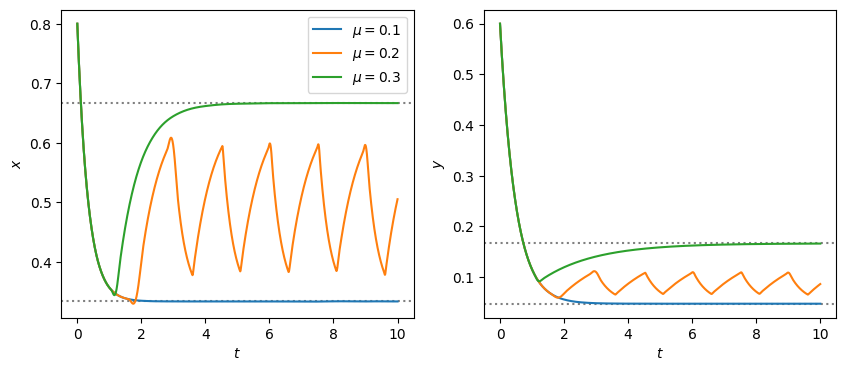

In [81]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$x$')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$y$')
(delta, gamma1, gamma0) = (0.1, 2, 0.5)
ax1.axhline(y=1/(1+gamma0), ls='dotted', color='gray')
ax1.axhline(y=1/(1+gamma1), ls='dotted', color='gray')
ax2.axhline(y=delta/(delta+gamma0), ls='dotted', color='gray')
ax2.axhline(y=delta/(delta+gamma1), ls='dotted', color='gray')
for mu in (0.1, 0.2, 0.3):
    sol = solve_ivp(f_welander, (0, 10), (0.8, 0.6), args=(delta, mu, gamma1, gamma0), t_eval=np.linspace(0, 10, 10000))
    ax1.plot(sol.t, sol.y[0], label=f'$\mu=${mu}')
    ax2.plot(sol.t, sol.y[1])
ax1.legend();

# Further reading

- Dansgaard-Oeschger events and millenial-scale variability of the meridional overturning circulation: Henk A. Dijkstra, *Nonlinear Climate Dynamics*, Cambridge University Press (2013), chapter 10.
- Numerical methods for integration of stochastic differential equations: P. E. Kloeden and E. Platen, *Numerical Solution of Stochastic Differential Equations*, Springer (2010).
- Diffusion in a potential and first-passage times: C. Gardiner, *Stochastic Methods*, Springer (2009), in particular section 5.5.

This problem is mostly based on section 10.5 of the book of Henk Dijkstra. The original papers cited above are the following:
- H. Stommel, *Thermohaline Convection with Two Stable Regimes of Flow*, Tellus 13, 224-230 (1961)
- P. Cessi, *A Simple Box Model of Stochastically Forced Thermohaline Flow*, J. Phys. Oceanogr. 24, 1911-1920 (1994)
- P. Vélez-Belchí, A. Alvarez, P. Colet, J. Tintoré and R. L. Haney, *Stochastic Resonance in the Thermohaline Circulation*, Geophys. Res. Lett. 28, 2053-2056 (2001)
- P. Welander, *A simple Heat-Salt Oscillator*, Dynamics of Atmospheres and Oceans, 6, 233-242 (1982)